# Alluvial plot

## Setup code and Import functions

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
import pickle
import warnings
import plotly.graph_objects as go
import matplotlib


In [6]:
def Area_category(coords,title):
    coords['year'] = coords.index
    coords['count']= 1
    coords[title] = 'NO' # Fill NaN

    # Area assignation:
    coords.loc[(coords['pc_w_'+direction]<1/3) & (coords['z_'+direction+'_overl']<2),title] ='A1'
    coords.loc[((coords['pc_w_'+direction]>=1/3) &(coords['pc_w_'+direction]<2/3)) & (coords['z_'+direction+'_overl']<2),title] ='A2'
    coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']<2),title] = 'A3'
    coords.loc[(coords['pc_w_'+direction]<1/3) & (coords['z_'+direction+'_overl']>=2),title] ='A4'
    coords.loc[((coords['pc_w_'+direction]>=1/3) &(coords['pc_w_'+direction]<2/3)) & (coords['z_'+direction+'_overl']>=2),title] ='A5'
    coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']>=2),title] ='A6'
    coords= coords.loc[:,['country',title]]
    return coords

def Area_category_and_vals(coords,title):
    coords['year'] = coords.index
    coords['count']= 1
    coords[title] = 'NO' # Fill NaN

    # Area assignation:
    coords.loc[(coords['pc_w_'+direction]<1/3) & (coords['z_'+direction+'_overl']<2),title] ='A1'
    coords.loc[((coords['pc_w_'+direction]>=1/3) &(coords['pc_w_'+direction]<2/3)) & (coords['z_'+direction+'_overl']<2),title] ='A2'
    coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']<2),title] = 'A3'
    coords.loc[(coords['pc_w_'+direction]<1/3) & (coords['z_'+direction+'_overl']>=2),title] ='A4'
    coords.loc[((coords['pc_w_'+direction]>=1/3) &(coords['pc_w_'+direction]<2/3)) & (coords['z_'+direction+'_overl']>=2),title] ='A5'
    coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']>=2),title] ='A6'
    coords= coords.loc[:,['z_'+direction+'_overl','pc_w_'+direction,'country',title]]
    return coords


def Prep_links_sankey(dict_results,pair_list, x):

    # Find Position of source and target nodes for each year pair
    source = dict_results[pair_list[x][0]]
    target = dict_results[pair_list[x][1]]

    source_out = Area_category (source, 'Area_s')
    target_out = Area_category (target, 'Area_t')

    # Merge source and target
    transfers = pd.merge(source_out, target_out, on='country') 

    transfers.loc[:,'counts']=transfers.groupby(['Area_s','Area_t']).transform('count')
    transfers = transfers.drop(columns='country').drop_duplicates().sort_values('Area_s')
    transfers['Area_s_y']=transfers.Area_s.astype('str') + ' ' + str(pair_list[x][0])
    transfers['Area_t_y']=transfers.Area_t.astype('str') + ' ' + str(pair_list[x][1])
    
    transfers['Area_s_cat'] = pd.Categorical(transfers['Area_s'], ['A6','A5', 'A4', 'A3','A2','A1','NO'],ordered=True)
    transfers['Area_t_cat'] = pd.Categorical(transfers['Area_t'],  ['A6','A5', 'A4', 'A3','A2','A1','NO'],ordered=True)
    transfers.sort_values(['Area_s_cat','Area_t_cat'], inplace = True)
    return transfers


def Choose_Color(x,colormap,flag_type ,constant_color= (0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 0.5)):
    if flag_type=='edge':
        link_colormap= {i: matplotlib.colors.to_rgba(colormap[i], alpha=0.5) for i in colormap}
        if x[3] ==x[4]: # if Area_s == Area_t
            color_to_use= constant_color
        else: 
            color_to_use = link_colormap[x[3]]
        return color_to_use
    else:
        link_colormap= {i: matplotlib.colors.to_rgba(colormap[i]) for i in colormap}
        color_to_use = link_colormap[x[:-5]]
    return color_to_use

# Preprocess data

In [13]:
# SPECIFY PARAMETERS & LOAD DATA 
direction= 'in'
unit_flag = 'dollars'
group_class = 'Food_group'#'Food_group'
N_splits = 4
constant_color = (0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 0.5)

with open('../Data/intermediate/particip_overlap/'+direction+'_overlap_particip_'+unit_flag+'_'+group_class+'.pkl', 'rb') as f:
    dict_in = pickle.load(f)
    
year_list = list(range(min(dict_in.keys()), 2022+1)) 

dict_results = {x: dict_in[x] for x in year_list if x in dict_in}

## Alluvial plot Sankeyflow

In [14]:
from sankeyflow import Sankey

def Define_years_alluvial (dict_results, splits = 0):
    
    split_years = list(dict_results.keys())
    if splits >=2:
        print('in splits')
        split_years =np.linspace(np.min(split_years),np.max(split_years),num=splits,dtype=int)
        print(split_years)
    else: 
        warnings.warn('The alluvial plot needs split >=2. Returning to default behaviour (splits = 0).')

    split_years.sort()

    print('Make sure year_list has the right order (ascending):\n',split_years) 

    pair_list= [(split_years[i],split_years[i+1]) for i in range(len(split_years)-1)]
    print('Pairs:\n', pair_list)
    return pair_list,split_years

dict_results

pair_list, split_years = Define_years_alluvial(dict_results, splits = N_splits)
print(pair_list)

in splits
[1986 1998 2010 2022]
Make sure year_list has the right order (ascending):
 [1986 1998 2010 2022]
Pairs:
 [(np.int64(1986), np.int64(1998)), (np.int64(1998), np.int64(2010)), (np.int64(2010), np.int64(2022))]
[(np.int64(1986), np.int64(1998)), (np.int64(1998), np.int64(2010)), (np.int64(2010), np.int64(2022))]


In [15]:
def Area_category(coords,title):
    coords['year'] = coords.index
    coords['count']= 1
    coords[title] = 'NO' # Fill NaN

    # Area assignation:
    coords.loc[(coords['pc_w_'+direction]<1/3) & (coords['z_'+direction+'_overl']<2),title] ='A1'
    coords.loc[((coords['pc_w_'+direction]>=1/3) &(coords['pc_w_'+direction]<2/3)) & (coords['z_'+direction+'_overl']<2),title] ='A2'
    coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']<2),title] = 'A3'
    coords.loc[(coords['pc_w_'+direction]<1/3) & (coords['z_'+direction+'_overl']>=2),title] ='A4'
    coords.loc[((coords['pc_w_'+direction]>=1/3) &(coords['pc_w_'+direction]<2/3)) & (coords['z_'+direction+'_overl']>=2),title] ='A5'
    coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']>=2),title] ='A6'
    coords= coords.loc[:,['country',title]]
    return coords

def Area_category_and_vals(coords,title):
    coords['year'] = coords.index
    coords['count']= 1
    coords[title] = 'NO' # Fill NaN

    # Area assignation:
    coords.loc[(coords['pc_w_'+direction]<1/3) & (coords['z_'+direction+'_overl']<2),title] ='A1'
    coords.loc[((coords['pc_w_'+direction]>=1/3) &(coords['pc_w_'+direction]<2/3)) & (coords['z_'+direction+'_overl']<2),title] ='A2'
    coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']<2),title] = 'A3'
    coords.loc[(coords['pc_w_'+direction]<1/3) & (coords['z_'+direction+'_overl']>=2),title] ='A4'
    coords.loc[((coords['pc_w_'+direction]>=1/3) &(coords['pc_w_'+direction]<2/3)) & (coords['z_'+direction+'_overl']>=2),title] ='A5'
    coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']>=2),title] ='A6'
    coords= coords.loc[:,['z_'+direction+'_overl','pc_w_'+direction,'country',title]]
    return coords


def Prep_links_sankey(dict_results,pair_list, x):

    # Find Position of source and target nodes for each year pair
    source = dict_results[pair_list[x][0]]
    target = dict_results[pair_list[x][1]]

    source_out = Area_category (source, 'Area_s')
    target_out = Area_category (target, 'Area_t')

    # Merge source and target
    transfers = pd.merge(source_out, target_out, on='country') 

    transfers.loc[:,'counts']=transfers.groupby(['Area_s','Area_t']).transform('count')
    transfers = transfers.drop(columns='country').drop_duplicates().sort_values('Area_s')
    transfers['Area_s_y']=transfers.Area_s.astype('str') + ' ' + str(pair_list[x][0])
    transfers['Area_t_y']=transfers.Area_t.astype('str') + ' ' + str(pair_list[x][1])
    
    transfers['Area_s_cat'] = pd.Categorical(transfers['Area_s'], ['A6','A5', 'A4', 'A3','A2','A1','NO'],ordered=True)
    transfers['Area_t_cat'] = pd.Categorical(transfers['Area_t'],  ['A6','A5', 'A4', 'A3','A2','A1','NO'],ordered=True)
    transfers.sort_values(['Area_s_cat','Area_t_cat'], inplace = True)
    return transfers


def Choose_Color(x,colormap,flag_type ,constant_color=constant_color):
    if flag_type=='edge':
        link_colormap= {i: matplotlib.colors.to_rgba(colormap[i], alpha=0.5) for i in colormap}
        if x[3] ==x[4]: # if Area_s == Area_t
            color_to_use= constant_color
        else: 
            color_to_use = link_colormap[x[3]]
        return color_to_use
    else:
        link_colormap= {i: matplotlib.colors.to_rgba(colormap[i]) for i in colormap}
        color_to_use = link_colormap[x[:-5]]
    return color_to_use

colormap = {'A1':'#CDB0B0','A2':'#C68E8E','A3':'#C06B6B','A4':'#B94949','A5':'#B94949','A6':'#B32626','NO':'lightgray'}

alluv_data = pd.concat([Prep_links_sankey(dict_results,pair_list, x) for x in range(len(pair_list))]).reset_index(drop=True)
alluv_data

# Define Node data: 
node_levels=list()
for y in split_years[0:-1]:
    data_y = alluv_data.loc[alluv_data.Area_s_y.str.contains(str(y)),:].copy(deep=True)
    data_y.sort_values(['Area_s_cat','Area_t_cat'], inplace = True)
    list_of_sources = [(categ, data_y.loc[alluv_data.Area_s_y== categ,'counts'].sum(),
                   {'color':Choose_Color(categ,colormap,'node'),  
                    'label':categ[:-5],
                    'label_format':'{label}','label_position':'center'})
                   for categ in data_y['Area_s_y'].unique()]
    
    node_architecture = [list_of_sources, list_of_sources]
    node_levels.append(list_of_sources)

# Add 2022 from target data 
data_y = alluv_data.loc[alluv_data.Area_t_y.str.contains('2022'),:].sort_values(['Area_t_cat'])
list_of_target = [(categ, data_y.loc[alluv_data.Area_t_y== categ,'counts'].sum(),
                   {'color': Choose_Color(categ,colormap,'node'),  
                    'label':categ[:-5],
                    'label_format':'{label}','label_position':'center'})
                   for categ in data_y['Area_t_y'].unique()]
node_levels.append(list_of_target)


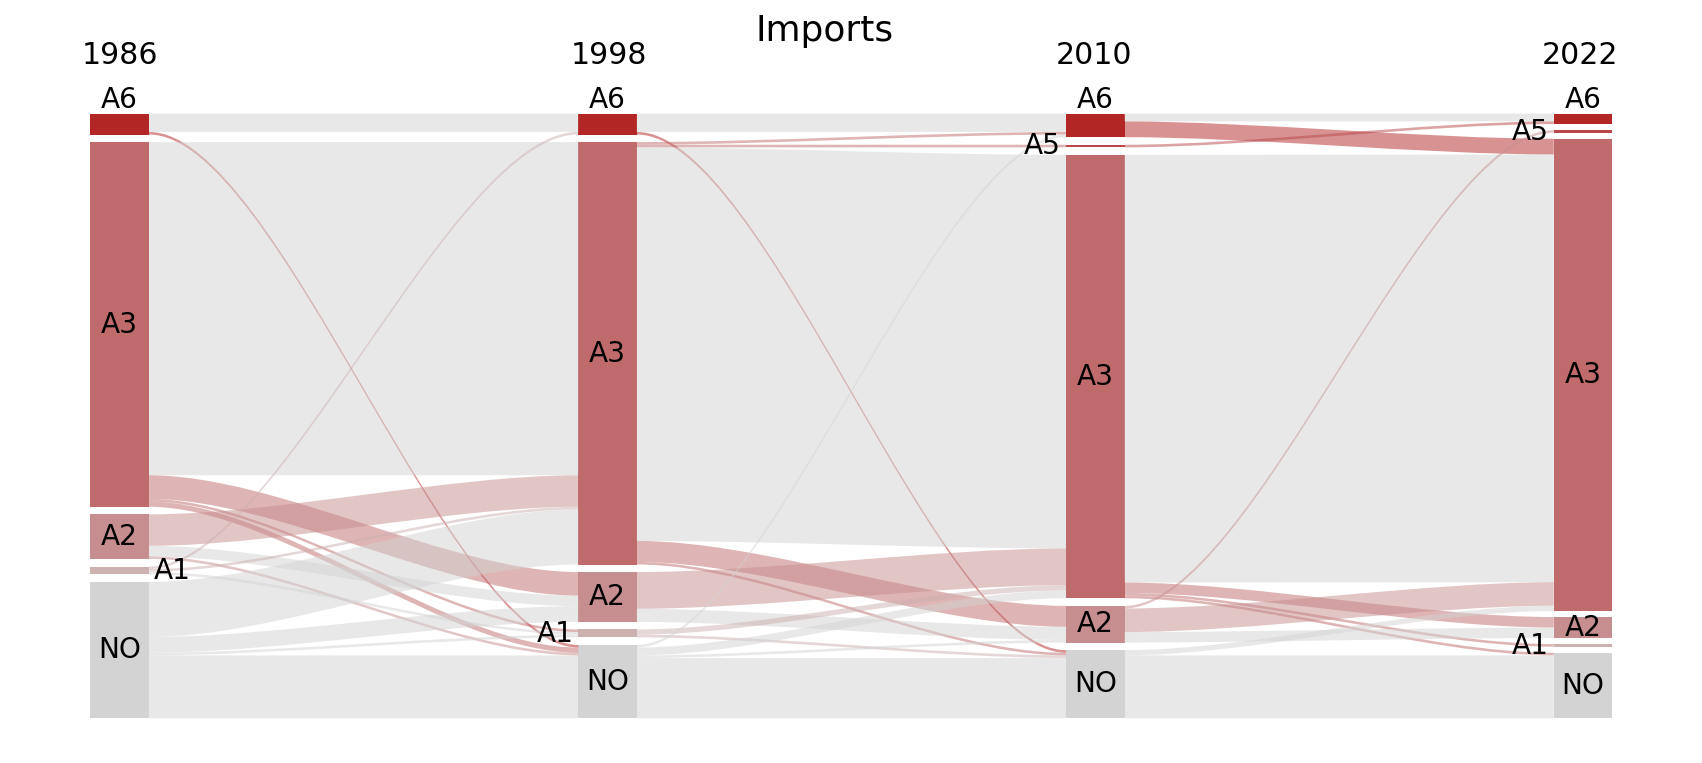

In [16]:

# flow list for only interseting nodes
#list_of_flows = [(x[0], x[1], x[2], {'color': color_edge}) for x in alluv_data.loc[:,['Area_s_y','Area_t_y','counts']].itertuples(index=False)]
list_of_flows = [(x[0], x[1], x[2], {'color':  Choose_Color(x,colormap,'edge',constant_color)}) for x in alluv_data.loc[:,['Area_s_y','Area_t_y','counts','Area_s','Area_t']].itertuples(index=False)]


#
fig, axs=plt.subplots(1, figsize=(15,6), dpi=144)

s = Sankey(
    flows=list_of_flows,
    nodes=node_levels,

)
# I am not sure if it is bugged but I cannot change it normally
node_width = 0.12

for x in set(alluv_data.Area_s_y.unique()).union(alluv_data.Area_t_y.unique()):
    node= s.find_node(x)[0]
    node.width = node_width
    if (node.value<=3) & (str(split_years.min()) in node.name): 
       node.label_pos = 'right'
    elif (node.value<=3) & (str(split_years.min()) not in node.name):
       node.label_pos = 'left'
    elif (node.label=='A6'):
        node.label_pos = 'top'
    else: 
        node.label_pos = 'center'


s.draw(ax = axs)

if direction == 'in':
    dir_title = 'Imports'
else: 
    dir_title = 'Exports'

# sp
axs.annotate(split_years[0], xy=(0.063, 1.03), xycoords='axes fraction', ha='center', fontsize=15)
axs.annotate(split_years[1], xy=(0.355, 1.03), xycoords='axes fraction', ha='center', fontsize=15)
axs.annotate(split_years[2], xy=(0.645, 1.03), xycoords='axes fraction', ha='center', fontsize=15)
axs.annotate(split_years[3], xy=(0.935, 1.03), xycoords='axes fraction', ha='center', fontsize=15)

fig.suptitle(f'{dir_title}', fontsize=18, y=0.96)
fig.savefig("../Plots/2023/Sankey_"+dir_title+".pdf",format='pdf')

## Covid check

In [17]:
pair_list

[(np.int64(1986), np.int64(1998)),
 (np.int64(1998), np.int64(2010)),
 (np.int64(2010), np.int64(2022))]

in splits
[2017 2018 2019 2020 2021 2022]
Make sure year_list has the right order (ascending):
 [2017 2018 2019 2020 2021 2022]
Pairs:
 [(np.int64(2017), np.int64(2018)), (np.int64(2018), np.int64(2019)), (np.int64(2019), np.int64(2020)), (np.int64(2020), np.int64(2021)), (np.int64(2021), np.int64(2022))]
[(np.int64(2017), np.int64(2018)), (np.int64(2018), np.int64(2019)), (np.int64(2019), np.int64(2020)), (np.int64(2020), np.int64(2021)), (np.int64(2021), np.int64(2022))]


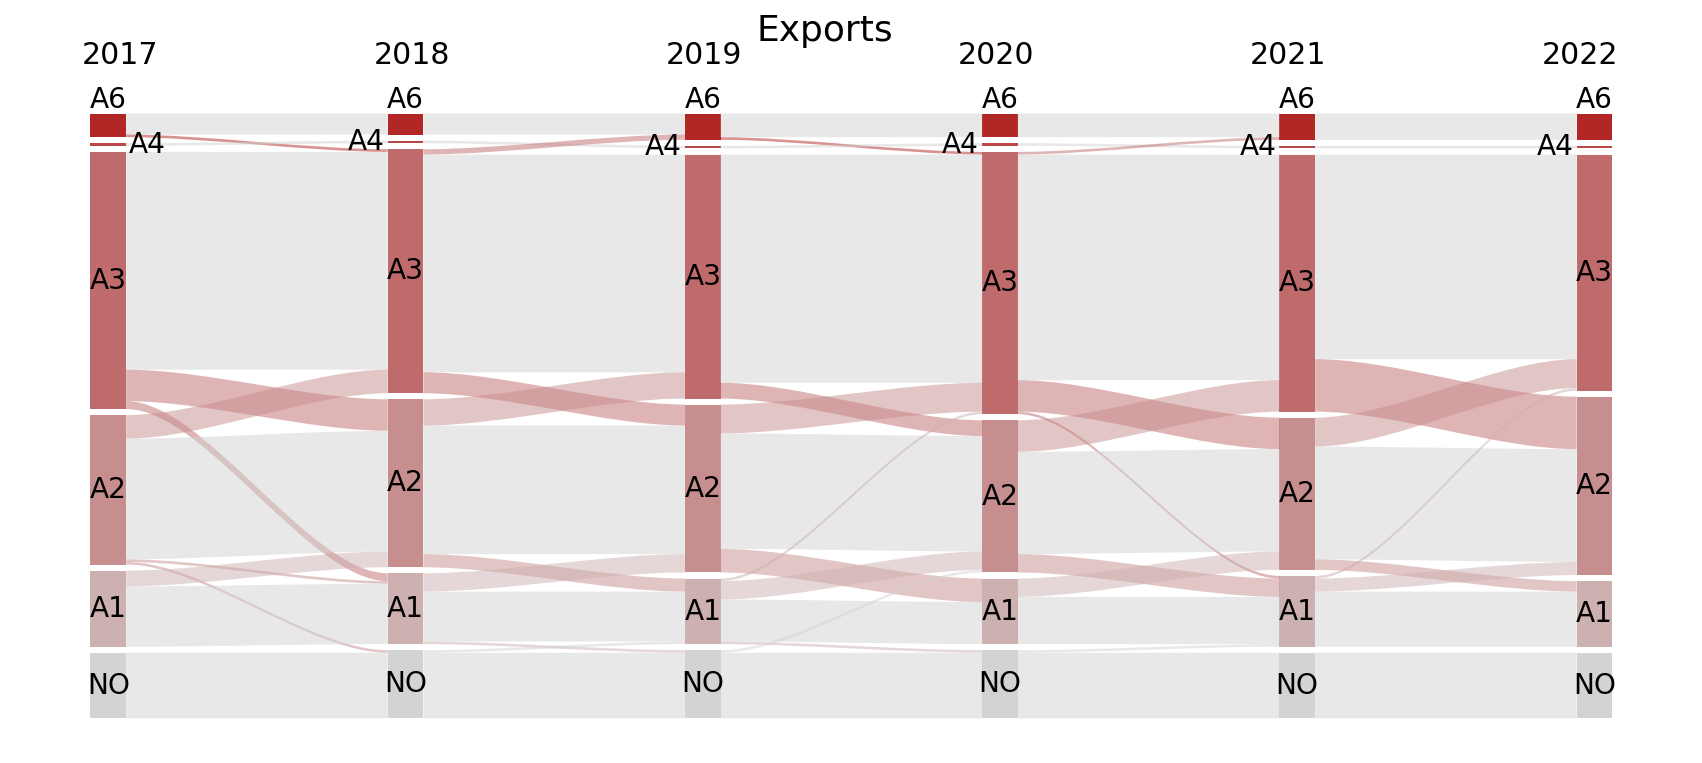

In [18]:
# SPECIFY PARAMETERS & LOAD DATA 
direction= 'out'
unit_flag = 'dollars'
group_class = 'Food_group'#'Food_group'
N_splits = 6
constant_color = (0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 0.5)

with open('../Data/intermediate/particip_overlap/'+direction+'_overlap_particip_'+unit_flag+'_'+group_class+'.pkl', 'rb') as f:
    dict_in = pickle.load(f)
    
year_list = list(range(2017, 2022+1)) 

dict_results = {x: dict_in[x] for x in year_list if x in dict_in}

pair_list, split_years = Define_years_alluvial(dict_results, splits = N_splits)
print(pair_list)

colormap = {'A1':'#CDB0B0','A2':'#C68E8E','A3':'#C06B6B','A4':'#B94949','A5':'#B94949','A6':'#B32626','NO':'lightgray'}

alluv_data = pd.concat([Prep_links_sankey(dict_results,pair_list, x) for x in range(len(pair_list))]).reset_index(drop=True)
alluv_data

# Define Node data: 
node_levels=list()
for y in split_years[0:-1]:
    data_y = alluv_data.loc[alluv_data.Area_s_y.str.contains(str(y)),:].copy(deep=True)
    data_y.sort_values(['Area_s_cat','Area_t_cat'], inplace = True)
    list_of_sources = [(categ, data_y.loc[alluv_data.Area_s_y== categ,'counts'].sum(),
                   {'color':Choose_Color(categ,colormap,'node'),  
                    'label':categ[:-5],
                    'label_format':'{label}','label_position':'center'})
                   for categ in data_y['Area_s_y'].unique()]
    
    node_architecture = [list_of_sources, list_of_sources]
    node_levels.append(list_of_sources)

# Add 2022 from target data 
data_y = alluv_data.loc[alluv_data.Area_t_y.str.contains('2022'),:].sort_values(['Area_t_cat'])
list_of_target = [(categ, data_y.loc[alluv_data.Area_t_y== categ,'counts'].sum(),
                   {'color': Choose_Color(categ,colormap,'node'),  
                    'label':categ[:-5],
                    'label_format':'{label}','label_position':'center'})
                   for categ in data_y['Area_t_y'].unique()]
node_levels.append(list_of_target)


# flow list for only interseting nodes
#list_of_flows = [(x[0], x[1], x[2], {'color': color_edge}) for x in alluv_data.loc[:,['Area_s_y','Area_t_y','counts']].itertuples(index=False)]
list_of_flows = [(x[0], x[1], x[2], {'color':  Choose_Color(x,colormap,'edge',constant_color)}) for x in alluv_data.loc[:,['Area_s_y','Area_t_y','counts','Area_s','Area_t']].itertuples(index=False)]


#
fig, axs=plt.subplots(1, figsize=(15,6), dpi=144)

s = Sankey(
    flows=list_of_flows,
    nodes=node_levels,

)
# I am not sure if it is bugged but I cannot change it normally
node_width = 0.12

for x in set(alluv_data.Area_s_y.unique()).union(alluv_data.Area_t_y.unique()):
    node= s.find_node(x)[0]
    node.width = node_width
    if (node.value<=3) & (str(split_years.min()) in node.name): 
       node.label_pos = 'right'
    elif (node.value<=3) & (str(split_years.min()) not in node.name):
       node.label_pos = 'left'
    elif (node.label=='A6'):
        node.label_pos = 'top'
    else: 
        node.label_pos = 'center'


s.draw(ax = axs)

if direction == 'in':
    dir_title = 'Imports'
else: 
    dir_title = 'Exports'

# annotate
for y in split_years:
    x_pos = 0.063 + (y - split_years[0]) * (0.935 - 0.063) / (split_years[-1] - split_years[0])
    axs.annotate(y, xy=(x_pos, 1.03), xycoords='axes fraction', ha='center', fontsize=15)
fig.suptitle(f'{dir_title}', fontsize=18, y=0.96)
fig.savefig("../Plots/2023/Sankey_"+dir_title+"_covid.pdf",format='pdf')

# Stability A6 agents

# OTHER THINGS

# Av. trend of countries in each area

In [4]:
# Estimate  if each country falls in A1, A2, A3, A4, A5, A6, NO
rownames = dict_results[1986].country

area_plane = pd.DataFrame(index=rownames)
for i in year_list:
    areas_year =Area_category_and_vals(dict_results[i],'Area')
    areas_year.set_index('country',inplace=True)
    areas_year.columns=[f'z_score_{i}',f'pc_{i}',f'Area_{i}']
    area_plane=pd.merge(area_plane,areas_year,left_index=True, right_index=True,how='outer')

area_plane

,z_score_1986,pc_1986,Area_1986,z_score_1987,pc_1987,Area_1987,z_score_1988,pc_1988,Area_1988,z_score_1989,...,Area_2016,z_score_2017,pc_2017,Area_2017,z_score_2018,pc_2018,Area_2018,z_score_2019,pc_2019,Area_2019
country,,,,,,,,,,,,,,,,,,,,,
AE,-0.063128,0.937972,A3,-0.085152,0.929362,A3,-0.079589,0.944885,A3,-0.027888,...,A3,0.664359,0.956125,A3,0.528685,0.954925,A3,0.566843,0.942427,A3
AF,-0.294725,0.750982,A3,-0.307580,0.675304,A3,-0.307982,0.556834,A2,-0.297240,...,A3,-0.233134,0.953216,A3,-0.224564,0.954789,A3,-0.258703,0.963656,A3
AG,-0.312135,0.699793,A3,-0.318524,0.767674,A3,-0.316649,0.757857,A3,-0.321696,...,A3,-0.368222,0.909978,A3,-0.362996,0.930293,A3,-0.357591,0.908800,A3
AL,-0.308016,0.624047,A2,-0.313030,0.607610,A2,-0.313483,0.712862,A3,-0.317238,...,A3,-0.344983,0.936344,A3,-0.343015,0.908002,A3,-0.333514,0.942061,A3
AM,-0.314426,NaN,NO,-0.320258,NaN,NO,-0.324338,NaN,NO,-0.328570,...,A3,-0.333969,0.942061,A3,-0.332821,0.933845,A3,-0.325597,0.944800,A3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YE,-0.314426,NaN,NO,-0.320240,0.000000,A1,-0.322300,0.000000,A1,-0.328570,...,A3,-0.204606,0.775253,A3,-0.175912,0.824024,A3,-0.134109,0.847003,A3
YU,0.015321,0.841905,A3,-0.065884,0.881116,A3,-0.092183,0.890134,A3,-0.081812,...,NO,-0.374758,NaN,NO,-0.370956,NaN,NO,-0.364271,NaN,NO
ZA,-0.213978,0.775318,A3,-0.240439,0.909082,A3,-0.244053,0.812344,A3,-0.269447,...,A3,-0.046449,0.915557,A3,-0.066601,0.917905,A3,-0.045755,0.924590,A3


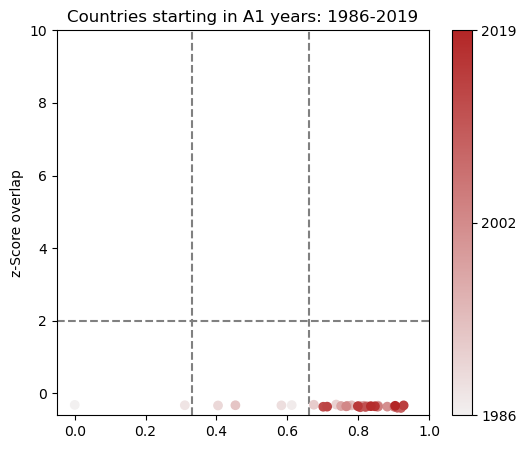

In [6]:
# Find countries starting from A3: 
import seaborn as sns

palette = sns.light_palette("#B32626",as_cmap=True)

#sns.light_palette("seagreen", as_cmap=True)
year_start = 1986
year_end=2019
area_check = 'A1'

#Area to choose 
area_start=area_plane.loc[(area_plane[f'Area_{year_start}']==area_check),:]
z_score_progress = area_start.loc[:,area_start.columns.str.contains('z_score')]

# z_score 95% confidence interval
z_score_stats=pd.concat([z_score_progress.median(axis=0),
                         z_score_progress.quantile([0.025,0.975],axis=0).T],axis=1)
z_score_stats.index=year_list
z_score_stats.columns=['Median','2.5%','97.5%']

# pc_coeff
pc_progress = area_start.loc[:,area_start.columns.str.contains('pc_')]

# Filter data to plot: 
z_score_stats = z_score_stats.loc[z_score_stats.index>=year_start,:]
z_score_stats = z_score_stats.loc[z_score_stats.index<=year_end,:]

# z_score 95% confidence interval
pc_progress_stats=pd.concat([pc_progress.median(axis=0),
                         pc_progress.quantile([0.025,0.975],axis=0).T],axis=1)
pc_progress_stats.index=year_list
pc_progress_stats.columns=['Median','2.5%','97.5%']


pc_progress_stats = pc_progress_stats.loc[pc_progress_stats.index>=year_start,:]
pc_progress_stats = pc_progress_stats.loc[pc_progress_stats.index<=year_end,:]

fig, ax=plt.subplots(figsize=(6,5))

#ax.plot(pc_progress_stats.Median,z_score_stats.Median,label='Median',color='lightgray',alpha=0.5,zorder=0)
ax.scatter(pc_progress_stats.Median,z_score_stats.Median,label='Median',c=pc_progress_stats.index,cmap=palette)
'''for year in pc_progress_stats.index:
    ax.annotate(year, (pc_progress_stats.loc[year,'Median'], z_score_stats.loc[year,'Median']))'''

ax.set_xlim([-0.05,1])
ax.set_ylim([-0.6,10])
plt.axhline(2,linestyle='--',color='gray',zorder =0)
plt.axvline(0.33,linestyle='--',color='gray',zorder =0)
plt.axvline(0.66,linestyle='--',color='gray',zorder =0)
ax.set_ylabel('z-Score overlap')
# do colorbar 
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=palette),ax=ax)
# change ticklabels colorbar
num_ticks = len(year_list)
cbar.set_ticks(ticks=np.linspace(0,1,num=3),labels=np.linspace(year_start,year_end,num=3).astype(int))
ax.set_title(f'Countries starting in {area_check} years: {year_start}-{year_end}')
year_end- year_start/2

fig.savefig(f'../Plots/Trajectory_start_{area_check}.pdf',dpi=300)

In [ ]:
# Plot individual trajectories
fig, ax=plt.subplots(figsize=(10,5))

for i in range(len(area_start)):
    ax.plot(pc_progress.iloc[i,:],z_score_progress.iloc[i,:])


ax.set_xlim([0,1])
ax.set_ylim([-1,10])
plt.axhline(2,linestyle='--',color='gray',zorder =0)
plt.axvline(0.33,linestyle='--',color='gray',zorder =0)
plt.axvline(0.66,linestyle='--',color='gray',zorder =0)


# Find dispersion of trade for A6

In [12]:
dict_results[i]

,country,out_overl,in_overl,out_deg,in_deg,z_in_deg,z_in_overl,pc_in,pc_w_in,year,count,Area
0,US,63486632.0,60645399.0,1569,1076,3.268577,6.693893,0.988353,0.925935,0,1,A6
1,BR,52219403.0,4704754.0,1105,347,0.228203,0.183288,0.974533,0.886026,1,1,A3
2,NL,37183511.0,31043539.0,1558,1018,3.026681,3.248705,0.990194,0.957101,2,1,A6
3,FR,34083402.0,21078057.0,1577,1008,2.984975,2.088881,0.989643,0.946774,3,1,A6
4,ES,29767036.0,16116196.0,1413,832,2.250948,1.511399,0.988406,0.950218,4,1,A3
...,...,...,...,...,...,...,...,...,...,...,...,...
214,BV,0.0,0.0,0,0,-1.218999,-0.364271,NaN,NaN,214,1,NO
215,CS,0.0,0.0,0,0,-1.218999,-0.364271,NaN,NaN,215,1,NO
216,BE-LU,0.0,0.0,0,0,-1.218999,-0.364271,NaN,NaN,216,1,NO
217,PR,0.0,0.0,0,0,-1.218999,-0.364271,NaN,NaN,217,1,NO


In [16]:
# Find countries in A6
# Estimate  if each country falls in A1, A2, A3, A4, A5, A6, NO
rownames = dict_results[1986].country

dict_A6 = dict()

# dict with i as key and list of countries as values

dict_A6={i:dict_results[i].loc[(dict_results[i]['pc_w_'+direction]>=2/3) & (dict_results[i]['z_'+direction+'_overl']>=2),'country'].to_list() for i in year_list}


dict_A6

{1986: ['US', 'FR', 'NL', 'BE-LU', 'GB', 'IT', 'SU', 'JP'],
 1987: ['US', 'FR', 'NL', 'BE-LU', 'GB', 'IT', 'SU', 'JP'],
 1988: ['US', 'FR', 'NL', 'BE-LU', 'IT', 'GB', 'SU', 'JP'],
 1989: ['US', 'FR', 'NL', 'BE-LU', 'IT', 'GB', 'SU', 'JP'],
 1990: ['US', 'FR', 'NL', 'BE-LU', 'IT', 'GB', 'JP', 'SU'],
 1991: ['US', 'FR', 'NL', 'DE', 'IT', 'BE-LU', 'GB', 'JP', 'SU'],
 1992: ['US', 'FR', 'NL', 'DE', 'BE-LU', 'IT', 'GB', 'JP'],
 1993: ['US', 'FR', 'NL', 'DE', 'BE-LU', 'IT', 'GB', 'JP'],
 1994: ['US', 'FR', 'NL', 'DE', 'BE-LU', 'IT', 'GB', 'JP'],
 1995: ['US', 'FR', 'NL', 'DE', 'BE-LU', 'IT', 'GB', 'CN', 'JP'],
 1996: ['US', 'FR', 'NL', 'DE', 'BE-LU', 'IT', 'GB', 'JP'],
 1997: ['US', 'FR', 'NL', 'DE', 'BE-LU', 'IT', 'GB', 'JP'],
 1998: ['US', 'FR', 'NL', 'DE', 'BE-LU', 'IT', 'GB', 'JP'],
 1999: ['US', 'FR', 'NL', 'DE', 'IT', 'BE-LU', 'GB', 'JP'],
 2000: ['US', 'FR', 'NL', 'DE', 'IT', 'BE', 'GB', 'JP'],
 2001: ['US', 'FR', 'NL', 'DE', 'IT', 'BE', 'CN', 'GB', 'JP'],
 2002: ['US', 'FR', 'NL', 'D

In [19]:
# import trade matrix

data_trade_og = pd.read_pickle('../Data/Data_trade_filt_production.pkl')
data_prod_og = pd.read_pickle('../Data/Data_prod_filt_production.pkl')
data_prod_og['unit']=data_prod_og['unit'].replace({'t':'tonnes'})

#Extract list of all countries 
countries_iso = data_trade_og[['origin_country','origin_country_ISO']].rename(columns={'origin_country':'country','origin_country_ISO':'ISO'})
countries_iso = pd.concat([countries_iso,data_trade_og[['destin_country','destin_country_ISO']].rename(columns={'destin_country':'country','destin_country_ISO':'ISO'})])
countries_iso = countries_iso.drop_duplicates().sort_values(by='country')

countries_iso

,country,ISO
47312,Afghanistan,AF
59696,Albania,AL
7182,Algeria,DZ
91098,Angola,AO
275550,Antigua and Barbuda,AG
...,...,...
9423758,Wake Island,UM-79
39432,Yemen,YE
277010,Yugoslav SFR,YU
65600,Zambia,ZM


In [20]:
data_trade_og

,destin_country_ISO,origin_country_ISO,item,item_code,year,unit,value,origin_country,destin_country,L1_foodex,Food_group
0,BY,UY,"Edible offals of horses and other equines, fr...",1098,2013,tonnes,7.0,Uruguay,Belarus,A01QR,Meat and meat products
1,BY,UY,"Edible offals of horses and other equines, fr...",1098,2013,1000 US$,8.0,Uruguay,Belarus,A01QR,Meat and meat products
2,BY,UY,"Horse meat, fresh or chilled",1097,2019,tonnes,49.6,Uruguay,Belarus,A01QR,Meat and meat products
3,BY,UY,"Horse meat, fresh or chilled",1097,2019,1000 US$,124.0,Uruguay,Belarus,A01QR,Meat and meat products
4,BY,UY,Wine,564,2005,tonnes,7.0,Uruguay,Belarus,A03LZ,Alcoholic beverages
...,...,...,...,...,...,...,...,...,...,...,...
12567443,ER,EE,Skim milk and whey powder,898,2000,1000 US$,127.0,Estonia,Eritrea,A02LR,Milk and dairy products
12567444,ER,BR,"Meat of chickens, fresh or chilled",1058,2004,tonnes,24.0,Brazil,Eritrea,A01QR,Meat and meat products
12567445,ER,BR,"Meat of chickens, fresh or chilled",1058,2006,tonnes,26.0,Brazil,Eritrea,A01QR,Meat and meat products
12567446,ER,BR,"Meat of chickens, fresh or chilled",1058,2004,1000 US$,18.0,Brazil,Eritrea,A01QR,Meat and meat products


In [ ]:
tonnes_data = data_trade_og.loc[data_trade_og['unit']=='t',:].reset_index(drop=True)
dollar_data = data_trade_og.loc[data_trade_og['unit']=='1000 USD',:].reset_index(drop=True)

tonnes_data

,destin_country_ISO,origin_country_ISO,item,item_code,year,unit,value,origin_country,destin_country,L1_foodex,Food_group
0,BY,UY,"Edible offals of horses and other equines, fr...",1098,2013,tonnes,7.0,Uruguay,Belarus,A01QR,Meat and meat products
1,BY,UY,"Horse meat, fresh or chilled",1097,2019,tonnes,49.6,Uruguay,Belarus,A01QR,Meat and meat products
2,BY,UY,Wine,564,2005,tonnes,7.0,Uruguay,Belarus,A03LZ,Alcoholic beverages
3,BY,UY,Apples,515,1998,tonnes,4.0,Uruguay,Belarus,A01BS,Fruit and fruit products
4,BY,UY,Apples,515,1999,tonnes,22.0,Uruguay,Belarus,A01BS,Fruit and fruit products
...,...,...,...,...,...,...,...,...,...,...,...
6283718,ER,EE,Skim milk and whey powder,898,1998,tonnes,16.0,Estonia,Eritrea,A02LR,Milk and dairy products
6283719,ER,EE,Skim milk and whey powder,898,1999,tonnes,96.0,Estonia,Eritrea,A02LR,Milk and dairy products
6283720,ER,EE,Skim milk and whey powder,898,2000,tonnes,96.0,Estonia,Eritrea,A02LR,Milk and dairy products
6283721,ER,BR,"Meat of chickens, fresh or chilled",1058,2004,tonnes,24.0,Brazil,Eritrea,A01QR,Meat and meat products


In [33]:
year_sum.groupby(['origin_country_ISO','year']).first()

value  log_value
origin_country_ISO year                      
AE                 1986   88999.00   4.949385
                   1987   87880.00   4.943890
                   1988  105990.00   5.025265
                   1989  109936.00   5.041140
                   1990  167390.00   5.223730
...                            ...        ...
ZW                 2017  322147.54   5.508055
                   2018  235745.69   5.372444
                   2019  309432.15   5.490565
                   2020  300904.13   5.478428
                   2021  237398.64   5.375478

[6976 rows x 2 columns]

In [58]:
group

,origin_country_ISO,year,value
33,AE,2019,2695553.64
69,AF,2019,935757.72
105,AG,2019,28296.69
141,AL,2019,148853.25
171,AM,2019,85375.29
...,...,...,...
6827,WS,2019,6080.02
6859,YE,2019,159107.31
6901,ZA,2019,7304426.25
6937,ZM,2019,264554.16


In [67]:
group.year.unique()[0]

np.int64(2019)

In [69]:
import seaborn as sns
year_sum= tonnes_data.groupby(['origin_country_ISO','year'],as_index=False)['value'].sum()
group=year_sum.groupby('year',as_index=False).get_group(2019)


y_to_check=group.year.unique()[0]

dict_A6[y_to_check]

group.loc[group.origin_country_ISO.isin(dict_A6[y_to_check]),:]
#year_sum.groupby('year',as_index=False).get_group(1986).loc[year_sum.groupby('year',as_index=False).get_group(1986).origin_country_ISO.isin(dict_A6[group['year'][0]]),:])

,origin_country_ISO,year,value
1310,CN,2019,1.407309e+07
1564,DE,2019,2.515385e+07
2118,FR,2019,4.699926e+07
2190,GB,2019,7.289529e+06
3037,IT,2019,8.360912e+06
3145,JP,2019,2.450686e+05
4675,NL,2019,2.783639e+07
6581,US,2019,1.401116e+08


In [70]:
# filter rows that have origin_country_ISO inside dict_A6 for each year

KeyError: np.int64(2020)

/home/ariadna/miniconda3/envs/house_trade/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1139788/3675345116.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_sum_filt_A6=year_sum_filt.groupby('year',as_index=False).apply(lambda group: group.loc[group.origin_country_ISO.


Text(0.5, 0.98, 'Exports distribution (in tonnes)')

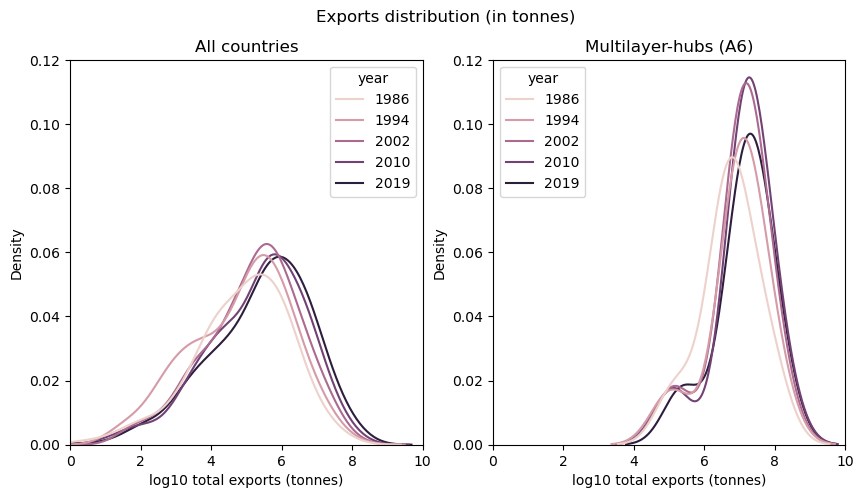

In [120]:
import seaborn as sns
log_flag = True
palette = sns.light_palette("#B32626",as_cmap=True)


year_sum= tonnes_data.groupby(['origin_country_ISO','year'],as_index=False)['value'].sum()


year_sum['log_value'] = np.log10(year_sum['value'])

# filt data for years

year_start = 1986
year_end=2019
steps= 5
# plot years 
range_plot = np.linspace(year_start,year_end,num =steps,dtype=int)

year_sum_filt = year_sum.loc[year_sum['year'].isin(range_plot),:]

year_sum_filt_A6=year_sum_filt.groupby('year',as_index=False).apply(lambda group: group.loc[group.origin_country_ISO.
                                                                        isin(dict_A6[group.year.unique()[0]]),:])

#plot distribution of trade for every year as a histogram
fig,ax = plt.subplots(1,2, figsize=(10,5))
if log_flag :
    sns.kdeplot(data=year_sum_filt, x='log_value',hue='year', clip=[0,None],ax=ax[0])
    sns.kdeplot(data=year_sum_filt_A6, x='log_value',hue='year', clip=[0,None],ax=ax[1])
    ax[1].set_xlabel('log10 total exports (tonnes)')
    ax[0].set_xlabel('log10 total exports (tonnes)')
    ax[0].set_xlim([0,10])
    ax[1].set_xlim([0,10])
    ax[0].set_ylim([None,0.12])
    ax[1].set_ylim([None,0.12])
else: 
#sns.histplot(data=year_sum_filt, x='value',hue='year',kde=True,stat='density',ax=ax[0])
    sns.kdeplot(data=year_sum_filt, x='value',hue='year', clip=[0,None],ax=ax[0])
    sns.kdeplot(data=year_sum_filt_A6, x='value',hue='year', clip=[0,None],ax=ax[1])
    ax[1].set_xlabel(' total exports (tonnes)')
    ax[0].set_xlabel('total exports (tonnes)')
    ax[0].set_xlim([None,2.3e8])
    ax[1].set_xlim([None,2.3e8])
#    ax[0].set_ylim([None,3e-8])
#    ax[1].set_ylim([None,3e-8])
# set commmon x axis tick values 
'''ax[0].set_xlim([None,2.3e8])
ax[1].set_xlim([None,2.3e8])
ax[0].set_ylim([None,4e-8])
ax[1].set_ylim([None,4e-8])'''

ax[0].set_title('All countries')
ax[1].set_title('Multilayer-hubs (A6)')


#ax[1].set_yticklabels([])


# plot distribution with a density graph
fig.suptitle(f'Exports distribution (in tonnes)')

In [91]:
year_sum_filt_A6


origin_country_ISO  year         value  log_value
0 472               BE-LU  1986  6.202138e+06   6.792541
  2085                 FR  1986  2.849495e+07   7.454768
  2157                 GB  1986  7.946601e+06   6.900181
  3004                 IT  1986  3.126903e+06   6.495114
  3112                 JP  1986  1.465960e+05   5.166122
  4642                 NL  1986  6.921796e+06   6.840219
  5900                 SU  1986  2.022438e+06   6.305875
  6548                 US  1986  8.455702e+07   7.927150
1 480               BE-LU  1994  7.885016e+06   6.896803
  1539                 DE  1994  1.710990e+07   7.233247
  2093                 FR  1994  3.526348e+07   7.547325
  2165                 GB  1994  7.116015e+06   6.852237
  3012                 IT  1994  6.353080e+06   6.802984
  3120                 JP  1994  1.162350e+05   5.065337
  4650                 NL  1994  1.360257e+07   7.133621
  6556                 US  1994  1.006575e+08   8.002846
2 452                  BE  2002  9.091564e+06   6.958639
  1293                 CN  2002  1.932270e+07   7.286068
  1547                 DE  2002  2.207742e+07   7.343948
  2101                 FR  2002  3.992719e+07   7.601269
  2173                 GB  2002  5.391342e+06   6.731697
  3020                 IT  2002  6.488715e+06   6.812159
  3128                 JP  2002  1.351890e+05   5.130941
  4658                 NL  2002  1.719888e+07   7.235500
  6564                 US  2002  1.234274e+08   8.091412
3 460                  BE  2010  1.105659e+07   7.043621
  1555                 DE  2010  2.729750e+07   7.436123
  2109                 FR  2010  4.919853e+07   7.691952
  2181                 GB  2010  9.323824e+06   6.969594
  3028                 IT  2010  8.959109e+06   6.952265
  3136                 JP  2010  1.298590e+05   5.113472
  4666                 NL  2010  2.441630e+07   7.387680
  5388                 RU  2010  1.587688e+07   7.200765
  6572                 US  2010  1.445673e+08   8.160070
4 1310                 CN  2019  1.407309e+07   7.148389
  1564                 DE  2019  2.515385e+07   7.400604
  2118                 FR  2019  4.699926e+07   7.672091
  2190                 GB  2019  7.289529e+06   6.862699
  3037                 IT  2019  8.360912e+06   6.922254
  3145                 JP  2019  2.450686e+05   5.389288
  4675                 NL  2019  2.783639e+07   7.444613
  6581                 US  2019  1.401116e+08   8.146474